In [3]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [4]:
import torch
import torch.nn as nn
from torchvision import models

# Define same architecture used during training
class CovidDenseNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CovidDenseNet, self).__init__()
        # Load DenseNet121 backbone
        self.backbone = models.densenet121(pretrained=False)
        num_ftrs = self.backbone.classifier.in_features
        # Replace classifier
        self.backbone.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Instantiate model
model = CovidDenseNet(num_classes=3)

# Load trained weights
checkpoint = torch.load("models/chexnet_finetuned.pth", map_location="cpu")
model.load_state_dict(checkpoint)
model.eval()

/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/minor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/fz/sd4mlm5j5xq82d0vlcyb4sgm0000gn/T/ipykernel_2648/2222166435.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defaul

CovidDenseNet(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [5]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.9226151704788208, 0.0684686154127121, 0.008916226215660572]


# Covid 19

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def compare_gradcam_layers_extended_densenet121(model, img_path, transform):
    """
    Compare Grad-CAM overlays across MANY valid convolutional layers of DenseNet121.
    Designed to give broad coverage from shallow to deep layers (most layers).
    """

    device = 'cpu'
    model.to(device)
    model.eval()

    # Load & preprocess
    rgb_img = np.float32(Image.open(img_path).convert('RGB').resize((224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # ---- Candidate conv2 layers across DenseNet121 ----
    # Block 1: 6 layers total
    b1 = {
        "denseblock1.denselayer1.conv2":  model.backbone.features.denseblock1.denselayer1.conv2,
        "denseblock1.denselayer3.conv2":  model.backbone.features.denseblock1.denselayer3.conv2,
        "denseblock1.denselayer6.conv2":  model.backbone.features.denseblock1.denselayer6.conv2,
    }

    # Block 2: 12 layers total
    b2 = {
        "denseblock2.denselayer3.conv2":  model.backbone.features.denseblock2.denselayer3.conv2,
        "denseblock2.denselayer6.conv2":  model.backbone.features.denseblock2.denselayer6.conv2,
        "denseblock2.denselayer9.conv2":  model.backbone.features.denseblock2.denselayer9.conv2,
        "denseblock2.denselayer12.conv2": model.backbone.features.denseblock2.denselayer12.conv2,
    }

    # Block 3: 24 layers total
    b3 = {
        "denseblock3.denselayer4.conv2":   model.backbone.features.denseblock3.denselayer4.conv2,
        "denseblock3.denselayer8.conv2":   model.backbone.features.denseblock3.denselayer8.conv2,
        "denseblock3.denselayer12.conv2":  model.backbone.features.denseblock3.denselayer12.conv2,
        "denseblock3.denselayer16.conv2":  model.backbone.features.denseblock3.denselayer16.conv2,
        "denseblock3.denselayer20.conv2":  model.backbone.features.denseblock3.denselayer20.conv2,
        "denseblock3.denselayer24.conv2":  model.backbone.features.denseblock3.denselayer24.conv2,
    }

    # Block 4: 16 layers total (include many)
    b4 = {
        "denseblock4.denselayer2.conv2":   model.backbone.features.denseblock4.denselayer2.conv2,
        "denseblock4.denselayer4.conv2":   model.backbone.features.denseblock4.denselayer4.conv2,
        "denseblock4.denselayer6.conv2":   model.backbone.features.denseblock4.denselayer6.conv2,
        "denseblock4.denselayer8.conv2":   model.backbone.features.denseblock4.denselayer8.conv2,
        "denseblock4.denselayer10.conv2":  model.backbone.features.denseblock4.denselayer10.conv2,
        "denseblock4.denselayer12.conv2":  model.backbone.features.denseblock4.denselayer12.conv2,
        "denseblock4.denselayer14.conv2":  model.backbone.features.denseblock4.denselayer14.conv2,
        "denseblock4.denselayer16.conv2":  model.backbone.features.denseblock4.denselayer16.conv2,  # last conv
    }

    # Merge all (order matters: shallow -> deep)
    candidate_layers = {**b1, **b2, **b3, **b4}

    targets = [ClassifierOutputTarget(0)]  # COVID-19 class index = 0

    n_layers = len(candidate_layers)
    n_cols = 4  # nice grid width for many layers
    n_rows = int(np.ceil((n_layers + 1) / n_cols))

    plt.figure(figsize=(4.5 * n_cols, 4.5 * n_rows))

    # Original image
    plt.subplot(n_rows, n_cols, 1)
    plt.title("Original")
    plt.imshow(rgb_img)
    plt.axis('off')

    # Generate Grad-CAM overlays
    for idx, (name, layer) in enumerate(candidate_layers.items(), start=2):
        cam = GradCAM(model=model, target_layers=[layer])
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        # Normalize to [0,1]
        grayscale_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)
        overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(n_rows, n_cols, idx)
        plt.title(name)
        plt.imshow(overlay)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


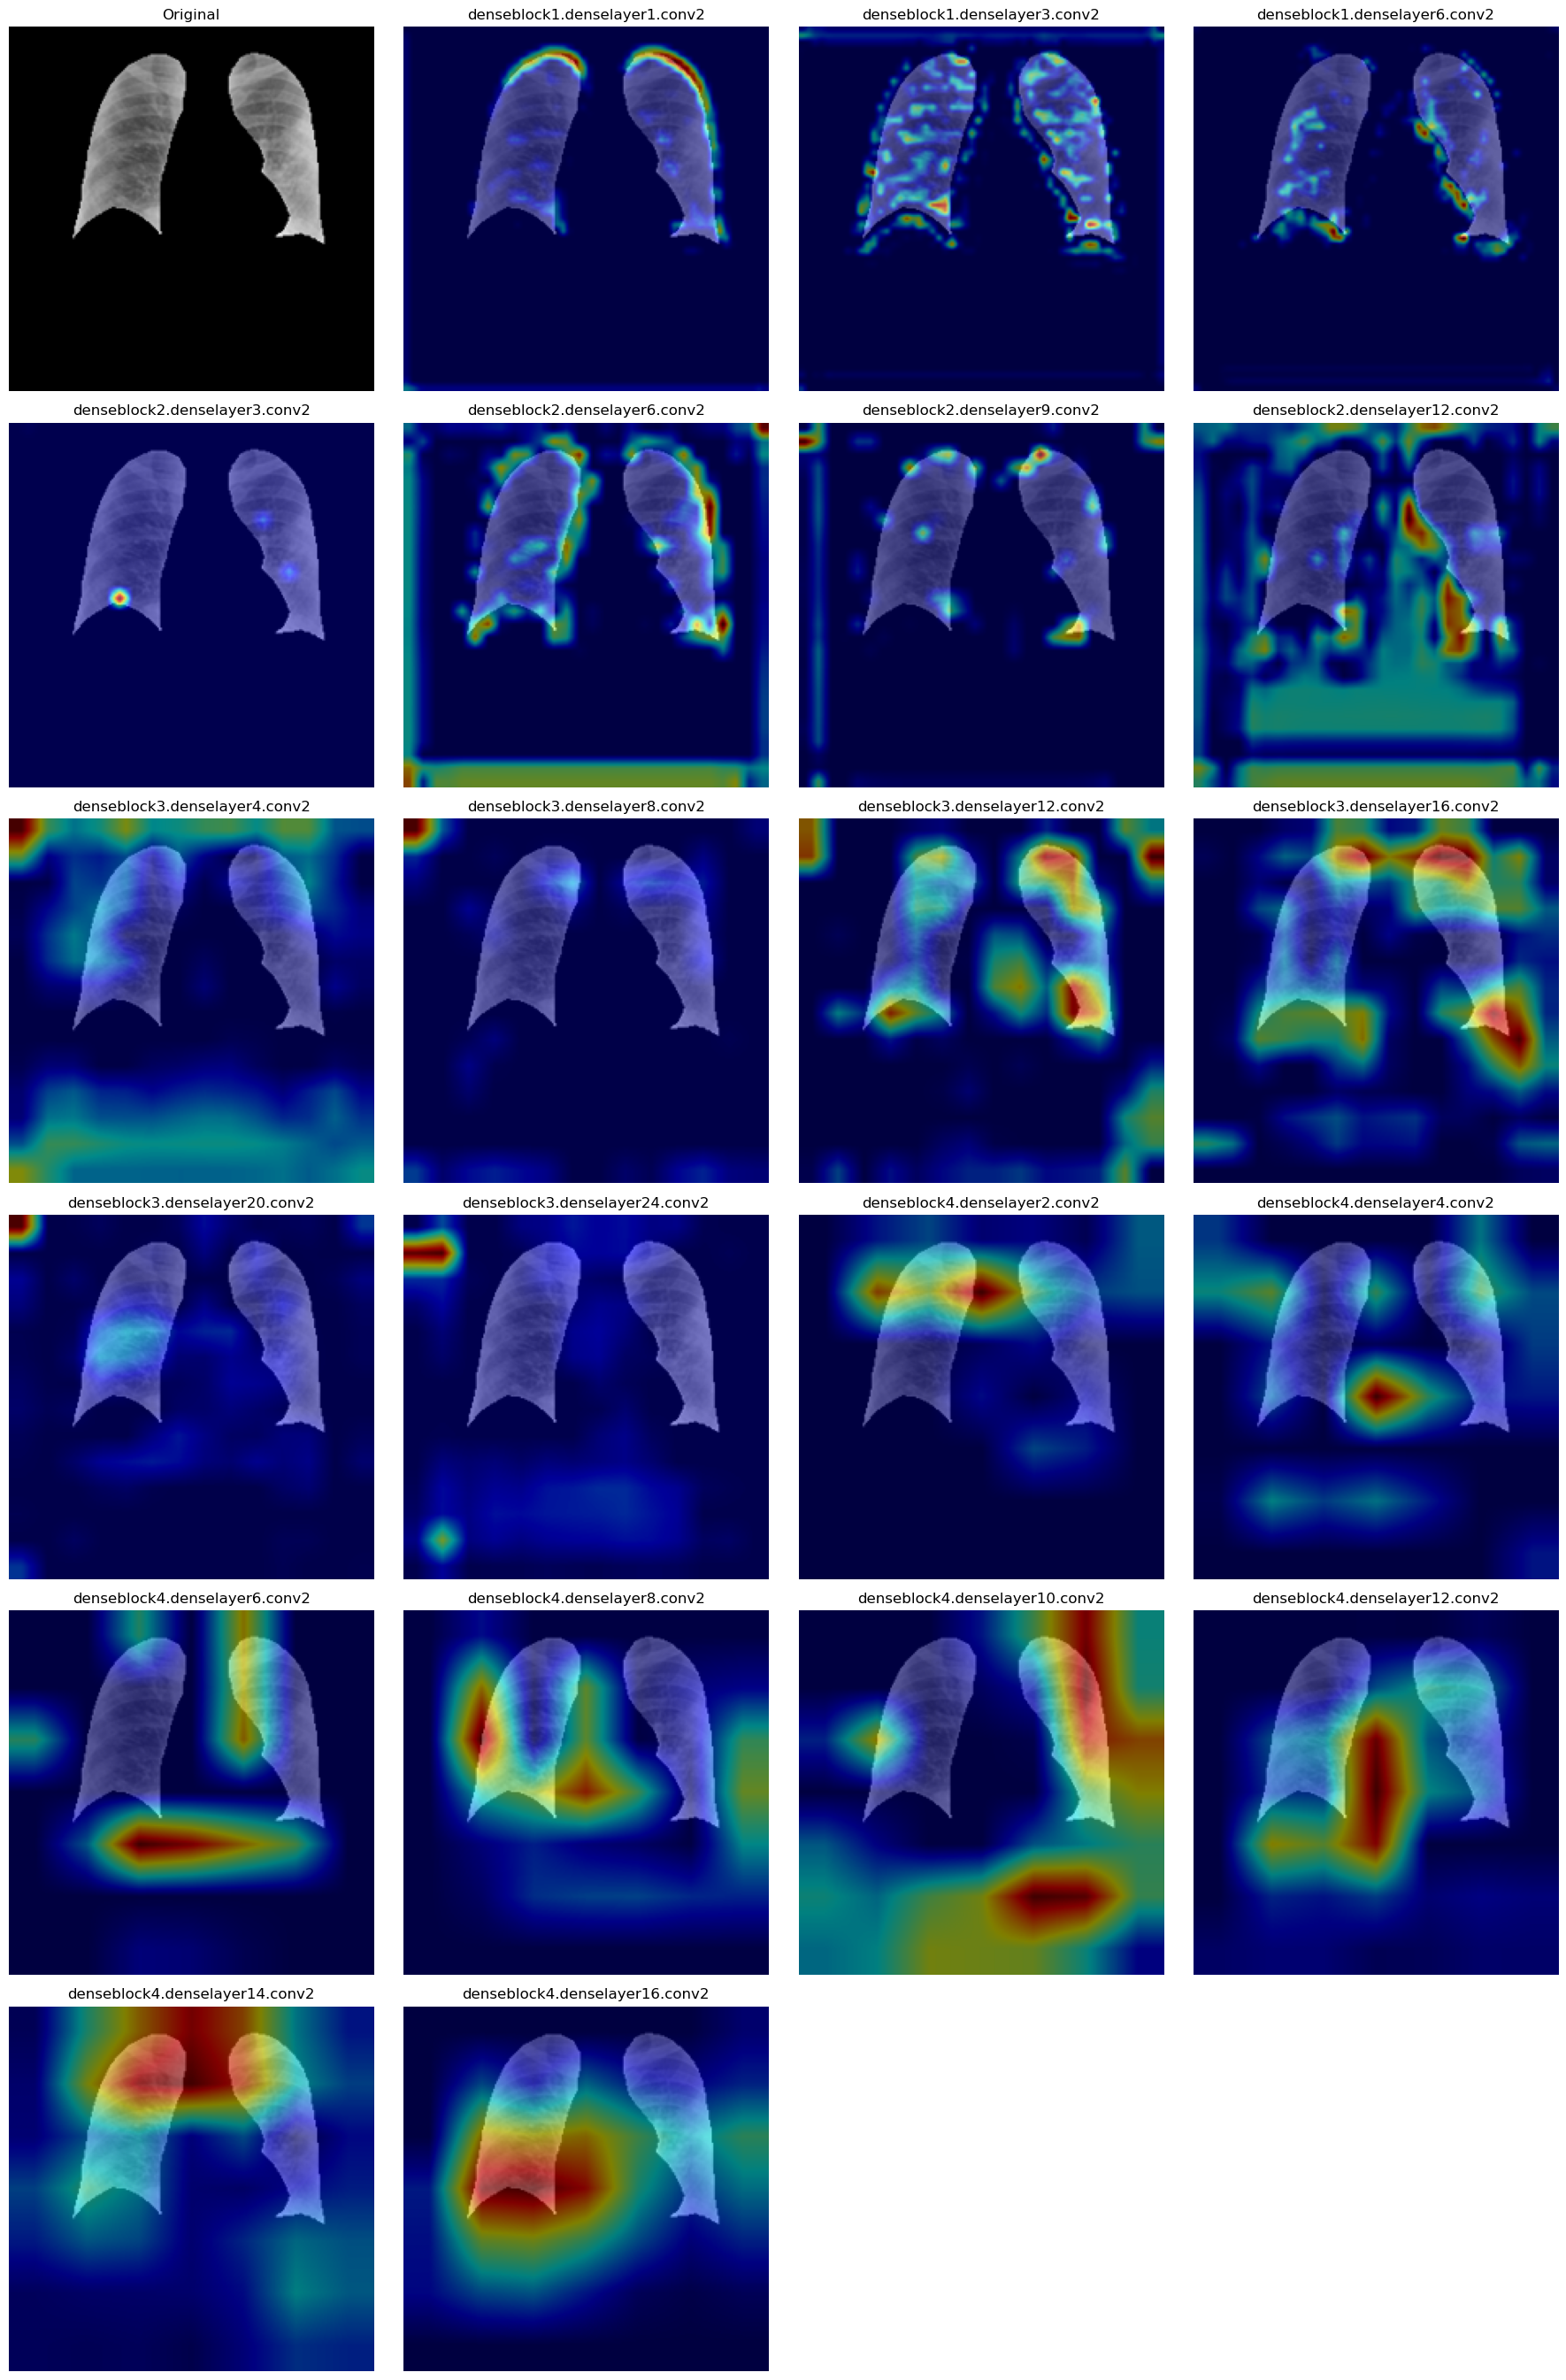

In [7]:
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
compare_gradcam_layers_extended_densenet121(model, img_path, transform)

# predicting infection mask

In [10]:
import torch
import numpy as np
import cv2
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def gradcam_infection_mask(model, img_path, transform, threshold=0.5):
    """
    Generate a binary infection mask (white = infected region, black = rest)
    using Grad-CAM for the COVID-19 class.

    Args:
        model: Trained DenseNet121 model
        img_path: Path to lung-segmented input image
        transform: Same preprocessing transform as training
        threshold: Float (0–1), cutoff for infection activation

    Returns:
        infection_binary: np.ndarray (uint8, shape [H, W]) — white infection, black otherwise
    """

    device = 'cpu'
    model.to(device)
    model.eval()

    # Load original image
    orig_img = np.array(Image.open(img_path).convert("RGB"))
    rgb_img = np.float32(cv2.resize(orig_img, (224, 224))) / 255.0

    # Apply same transform as training
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # ✅ Use denselayer12.conv2 for better spatial detail
    target_layer = model.backbone.features.denseblock4.denselayer16.conv2

    # Generate Grad-CAM heatmap
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0, :]  # COVID class = 0

    # Normalize to [0, 1]
    heatmap = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)

    # Resize Grad-CAM to match original image size
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

    # Threshold Grad-CAM to isolate high-activation (infection) regions
    infection_mask = np.uint8(heatmap_resized > threshold)

    # Extract lung segmentation mask (non-black pixels)
    gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    lung_mask = np.uint8(gray > 10)

    # Restrict infection to lung region
    infection_mask = infection_mask * lung_mask

    # Convert to binary (white infection, black rest)
    infection_binary = np.uint8(infection_mask * 255)

    # Optional smoothing for cleaner mask edges
    infection_binary = cv2.medianBlur(infection_binary, 5)

    return infection_binary


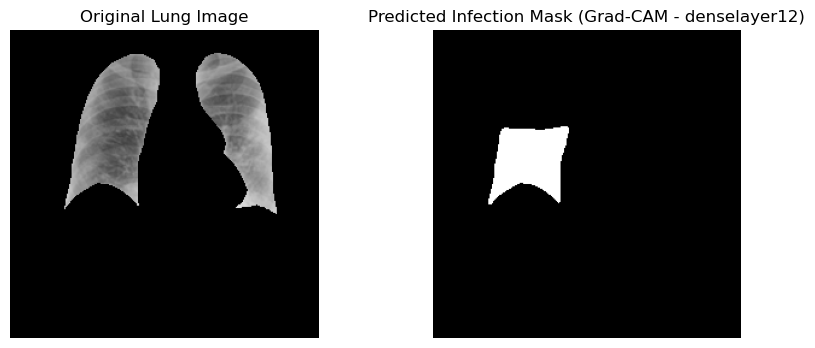

In [11]:
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"

infection_mask = gradcam_infection_mask(
    model,
    img_path,
    transform,
    threshold=0.55  # you can tune between 0.45–0.6
)

# Visualize result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Lung Image")
plt.imshow(Image.open(img_path))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Infection Mask (Grad-CAM - denselayer12)")
plt.imshow(infection_mask, cmap='gray')
plt.axis('off')
plt.show()

# save prediction maks

In [12]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# === CONFIGURATION ===
test_folder = "covid_qu_ex_masked/test/COVID-19"
save_root = "predicted_infection_masks/GradCAM_cheXCaps121/test/COVID-19"
os.makedirs(save_root, exist_ok=True)

# Use the desired Grad-CAM layer and threshold
target_layer = model.backbone.features.denseblock4.denselayer12.conv2   # ✅ DenseNet121 layer
threshold = 0.6

# CPU mode
device = 'cpu'
model.to(device)
model.eval()


# === FUNCTION: Generate Binary Infection Mask ===
def generate_gradcam_mask_densenet121(model, img_path, transform, target_layer, threshold=0.6):
    """
    Generate binary infection mask (white=infection, black=normal) using Grad-CAM for DenseNet121.
    """

    # Load image and preprocess
    orig_img = np.array(Image.open(img_path).convert("RGB"))
    rgb_img = np.float32(cv2.resize(orig_img, (224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0, :]  # COVID class = 0

    # Normalize Grad-CAM
    heatmap = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)

    # Resize heatmap to original image size
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

    # Threshold Grad-CAM to binary mask
    infection_mask = np.uint8(heatmap_resized > threshold)

    # Extract lung mask (non-black pixels)
    gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    lung_mask = np.uint8(gray > 10)

    # Restrict Grad-CAM infection mask to lung area
    infection_mask = infection_mask * lung_mask

    # Convert to binary (white infection, black rest)
    infection_binary = np.uint8(infection_mask * 255)

    # Optional smoothing
    infection_binary = cv2.medianBlur(infection_binary, 5)

    return infection_binary

In [13]:
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith((".png", ".jpg"))]

for filename in tqdm(image_files, desc="Generating Grad-CAM infection masks (DenseNet121)", unit="image"):
    img_path = os.path.join(test_folder, filename)
    try:
        infection_mask = generate_gradcam_mask_densenet121(model, img_path, transform, target_layer, threshold)
        save_path = os.path.join(save_root, filename)
        cv2.imwrite(save_path, infection_mask)
    except Exception as e:
        print(f"⚠️ Skipping {filename}: {e}")

print(f"✅ {len(image_files)} Grad-CAM infection masks (DenseNet121) saved successfully in '{save_root}'")


Generating Grad-CAM infection masks (DenseNet121): 100%|██████████| 583/583 [02:14<00:00,  4.33image/s]

✅ 583 Grad-CAM infection masks (DenseNet121) saved successfully in 'predicted_infection_masks/GradCAM_cheXCaps121/test/COVID-19'


In [14]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) > 0 else 1.0

def hausdorff_distance(y_true, y_pred):
    true_points = np.column_stack(np.where(y_true))
    pred_points = np.column_stack(np.where(y_pred))
    if len(true_points) == 0 or len(pred_points) == 0:
        return np.nan
    forward_hd = directed_hausdorff(true_points, pred_points)[0]
    backward_hd = directed_hausdorff(pred_points, true_points)[0]
    return max(forward_hd, backward_hd)

In [15]:
def evaluate_mask_metrics(gt_folder, pred_folder):
    gt_files = {f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg'))}
    pred_files = {f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg'))}

    # Find common filenames present in both folders
    common_files = sorted(list(gt_files & pred_files))

    if not common_files:
        print("No matching filenames found between predicted and ground truth folders.")
        return None

    metrics = {
        'iou': [], 'dice': [], 'accuracy': [],
        'precision': [], 'recall': [], 'f1_score': [], 'hausdorff': []
    }

    for filename in common_files:
        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(pred_folder, filename)

        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        if gt_mask is None or pred_mask is None:
            continue  # Skip any missing file read
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]))

        # Convert to binary 0-1
        gt_mask = (gt_mask > 0).astype(np.uint8)
        pred_mask = (pred_mask > 0).astype(np.uint8)

        gt_flat = gt_mask.flatten()
        pred_flat = pred_mask.flatten()

        metrics['iou'].append(iou_score(gt_mask, pred_mask))
        metrics['dice'].append(dice_score(gt_mask, pred_mask))
        metrics['accuracy'].append(accuracy_score(gt_flat, pred_flat))
        metrics['precision'].append(precision_score(gt_flat, pred_flat, zero_division=0))
        metrics['recall'].append(recall_score(gt_flat, pred_flat, zero_division=0))
        metrics['f1_score'].append(f1_score(gt_flat, pred_flat, zero_division=0))
        metrics['hausdorff'].append(hausdorff_distance(gt_mask, pred_mask))

    avg_metrics = {k: np.nanmean(v) for k, v in metrics.items()}
    return avg_metrics


# Example usage
ground_truth_folder = "covid_qu_ex/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks"
predicted_mask_folder = "predicted_infection_masks/GradCAM_cheXCaps121/test/COVID-19"

results = evaluate_mask_metrics(ground_truth_folder, predicted_mask_folder)

if results:
    print("\n📊 Evaluation results for Grad-CAM infection masks:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")


📊 Evaluation results for Grad-CAM infection masks:
iou: 0.1257
dice: 0.1960
accuracy: 0.8715
precision: 0.4613
recall: 0.1469
f1_score: 0.1960
hausdorff: 126.3200
